
<h1 style="text-align: center">Wie baut man eine KI mit Reinforcement Learning?</h1>

---

<div style="display: flex; justify-content: center; gap: 1em; align-items: center;">
<h5 style="text-align: center">Autor: Daniel Flat &copy; <a href="https://creativecommons.org/licenses/by-sa/4.0/" target="_blank">CC BY-SA 4.0</a></h5>
<img style="height: 3em;" src="https://www.wps.de/assets/img/logo-wps-2023.svg" alt="SVG Image">
</div>


In diesem Notebook bauen wir eine einfache KI, die lernt, ein Pendel oben zu halten.

Dafür verwenden wir die *[Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/)-Umgebung von OpenAI*, da das wie das *"Hello-World"-Beispiel für RL* ist.

<div style="display: flex; justify-content: center;">
<img src="https://gymnasium.farama.org/_images/pendulum.gif">
</div>

Dazu verwenden wir **Reinforcement Learning**. Genauer gesagt den **"[Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971)"-Algorithmus**. Das ist ein **einfacher** Ansatz, um eine Reinforcement-Learning KI zu **trainieren**, die in einer Umgebung agiert und dabei eine Belohnung erhält. Die KI lernt dabei, welche Aktionen sie in welchen Situationen ausführen muss, um die maximale Belohnung zu erhalten.

In diesem Notebook verwenden wir das **[PyTorch](https://pytorch.org/)-Framework**, um die KI zu implementieren. PyTorch ist ein beliebtes Framework für Deep Learning und bietet viele nützliche Funktionen, die uns bei der Implementierung der KI helfen.

---

**Vorkenntnisse für neuronale Netze sind hilfreich. Ansonsten gibt es viele Kommentare, den den KI-Teil erklären, sodass man auch ohne Vorkenntnisse weiterkommt. 🔝**

## Starten wir! 💪

### Schritt 01: Importieren der Libraries
Stellt sicher, dass die Imports korrekt sind und keine Fehler auftreten.
Ggf. muss man noch die notwendigen Bibliotheken installieren. Führt dazu ggf. den folgenden Codeblock aus.

In [1]:
!pip install "gymnasium[box2d]" numpy torch matplotlib pygame
print("-------------------------------------------------------")
print("Python Packages erfolgreich installiert! 👍")

-------------------------------------------------------
Python Packages erfolgreich installiert! 👍


Nun können wir die notwendigen Bibliotheken importieren.

In [3]:
# IMPORTS
import time
import numpy as np
import torch
import torch.nn as nn
import gymnasium
import pygame
import random
from collections import deque
from typing import Any, Tuple
import matplotlib.pyplot as plt

from torch import Tensor

print("Imports haben funktioniert! 👍")

Imports haben funktioniert! 👍


### Schritt 02 (optional): Pendulum selber ausprobieren
Bevor wir einen Agenten bauen, testen wir das Pendulum-Spiel einmal selber aus. Dazu müssen wir den nächsten Codeblock ausführen.

Dann öffnet sich ein **PyGame** Fenster, in dem wir das Pendulum steuern können. Das Ziel ist es, das Pendulum so lange wie möglich oben in der senkrechten Position zu halten. Dazu können wir die *linke* und *rechte* Pfeiltaste verwenden.


⬅️ Bewege Pendel nach links

➡️ Bewege Pendel nach rechts


Die Konsole gibt dann an, wie gut der Score am Ende ist. Wenn das Spiel vorbei ist, könnt ihr das Fenster wieder schließen und mit dem Notebook weitermachen.


Eine gut trainierte KI erhält im Schnitt eine Gesamtbelohnung von etwa -300 bis 0. Das werdet ihr wahrscheinlich nicht schaffen. Das ist nur eine kleine Herausforderung für euch. 😉

Schaut euch den Code an. Das ist ganz **einfache Game-Loop**, der die Tastatureingaben abfragt und die Aktionen an die Umgebung weitergibt.

In [4]:
SEED = 24  # Seed für die Reproduzierbarkeit

# Eine Klasse, die die Aktionen des menschlichen Spielers abfragt
class HumanAgent():
    def __init__(self):
        pass

    def act(self, state):
        # Wenn keine Taste gedrückt wird, ist die Aktion 0.0 = nichts tun
        action = np.array([0.0])

        keys = pygame.key.get_pressed()
        # Wenn die linke Pfeiltaste gedrückt wird, ist die Aktion -2.0 = maximales Drehmoment nach links
        if keys[pygame.K_LEFT]:
            action = np.array([-2.0])
        # Wenn die rechte Pfeiltaste gedrückt wird, ist die Aktion 2.0 = maximales Drehmoment nach rechts
        elif keys[pygame.K_RIGHT]:
            action = np.array([2.0])
        return action

# Wir erstellen uns die Umgebung und starten.
pygame.init()
env = gymnasium.make('Pendulum-v1', render_mode="human")
human_agent = HumanAgent()
state, _ = env.reset(seed=SEED)  # Startzustand
done = False  # Ist das Spiel vorbei?
total_reward = 0  # Gesamtbelohnung
print(f"Startzustand: {state} | X-coord: {state[0]:.4f} | Y-coord: {state[1]:.4f} | Drehgeschwindigkeit: {state[2]:.4f}")

# Solange das Spiel nicht vorbei ist
while not done:
    # Wir rendern die Umgebung
    env.render()

    # Wir fragen den Benutzer nach einer Aktion
    action = human_agent.act(state)

    # Wir führen die Aktion aus. Die Funktion gibt uns den nächsten Zustand, die Belohnung, ob das Spiel vorbei ist.
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Wir aktualisieren die Variablen
    state = next_state
    total_reward += reward
    done = terminated or truncated
pygame.quit()
env.close()
print("-------------------------------------------------------")
print(f"Episode vorbei! Gesamtbelohnung: {total_reward}")

Startzustand: [ 0.4832332  -0.8754917  -0.18964536] | X-coord: 0.4832 | Y-coord: -0.8755 | Drehgeschwindigkeit: -0.1896
-------------------------------------------------------
Episode vorbei! Gesamtbelohnung: -869.9079603628576


### Aber wie können wir jetzt eine KI bauen?
Zuvor haben wir die Klasse `HumanAgent` verwendet, um die Aktionen vom menschlichen Spielers abzufragen. Jetzt wollen wir aber eine KI bauen, die das Spiel spielt.

Anhand der Game-Loop sehen wir, dass die *Pendulum*-Umgebung einen *Markov-Decision Process (MDP)* darstellt. Das bedeutet, dass die Umgebung in einen Zustand `state` hat und der Agent eine Aktion `action` ausführt, um in einen neuen Zustand `next_state` zu gelangen. Dabei erhält der Agent eine Belohnung `reward`, die ihm sagt, wie gut die Aktion war. Das Spiel terminiert, sobald die Flag `done=True` ist.

<div style="display: flex; justify-content: center;">
    <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0952197622002512-gr2.jpg">
</div>

---

In diesem Abschnitt bauen wir eine KI, die das Pendulum spielt. Dazu verwenden wir den **Deep Deterministic Policy Gradient (DDPG)** Algorithmus aus dem Vortrag.

Wir haben hier 4. Python-Klassen:
1. `ReplayBuffer`: Speichert die Erfahrungen des Agenten, um sie später zum Training zu verwenden.
2. `Actor`: Das Policy-Netzwerk, das die Aktionen des Agenten bestimmt.
3. `Critic`: Das Q-Netzwerk, das den Q-Wert für einen Zustand und eine Aktion schätzt.
4. `DDPGAgent`: Der Agent, den wir trainieren wollen.

Anschließend gibt es noch die aktualisierte Game-Loop für das **Training des Agenten**.

Tipp: Die ganze Logik ist aus Übersichtsgründen in mehrere Cells aufgeteilt. Ihr könnt die auch **zusammen mergen, um besser zu debuggen**!




In [5]:
# Wir definieren die Klasse `ReplayMemory`, die uns hilft, die Erfahrungen des Agenten zu speichern.
# Das ist notwendig, um die KI zu trainieren.
# Die Klasse speichert die Zustände, Aktionen, Belohnungen, nächsten Zustände und ob das Spiel vorbei ist.
# Wir sampeln dann **zufällig** aus diesen Erfahrungen, um die KI zu trainieren, damit wir keine temporalen Korrelationen haben.
class ReplayBuffer:
    def __init__(self, capacity, device: torch.device) -> None:
        """
        Initialisiere den Replay-Speicher mit einer gegebenen Kapazität.
        :param capacity: Maximale Anzahl an gespeicherten Übergängen.
        """
        self.storage = deque([], maxlen=capacity)
        self.device = device

    def push(self, state: torch.Tensor, action: torch.Tensor, reward: torch.Tensor,
             next_state: torch.Tensor, done: torch.Tensor) -> None:
        """
        Speichere einen Übergang im Replay-Speicher.
        """
        self.storage.append((state, action, reward, next_state, done))

    def sample(self, batch_size=1) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
        """
        Ziehe eine Batch von Übergängen aus dem Speicher.
        """

        # Random batch
        batch = random.sample(self.storage, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Konvertiere die Objekte in torch.Tensor's mit den richtigen Shapes
        states = torch.vstack(states).to(self.device)
        actions = torch.vstack(actions).to(self.device)
        rewards = torch.vstack(rewards).to(self.device)
        next_states = torch.vstack(next_states).to(self.device)
        dones = torch.vstack(dones).to(self.device)

        return states, actions, rewards, next_states, dones

In [10]:
# der Actor nimmt einen Zustand und gibt eine Aktion zurück
# der Actor ist das Policy-Netzwerk, das die Aktionen des Agenten bestimmt
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super().__init__()

        self.actor_net = nn.Sequential(
            nn.Linear(state_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, action_size),
            nn.Tanh()  # Tanh is important here. Mappt die Aktion auf -1 bis 1
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        action = self.actor_net(state)
        return 2 * action


# der Critic nimmt einen Zustand und eine Aktion und schätzt den Q-Wert für diesen Zustand und diese Aktion
# den Critic verwenden wir, um den Fehler des Actors zu berechnen. Nach dem Training brauchen wir den Critic nicht mehr.
class Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super().__init__()

        self.critic_net = nn.Sequential(
            nn.Linear(state_size + action_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        q_value = self.critic_net(input)
        return q_value

    def estimate_q_value(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        input = torch.hstack((state, action))
        q_value = self.critic_net(input)
        return q_value

# Der Agent, den wir trainieren wollen
class DDPGAgent:
    def __init__(self, state_size: int, action_size: int, discount: float, optim_iter: int, batch_size: int, actor_lr: float, critic_lr: float, device: torch.device, noise_factor: float):
        super().__init__()
        # wir speichern die Parameter ab
        self.state_size = state_size
        self.action_size = action_size
        self.discount = discount
        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.device = device
        self.noise_factor = noise_factor
        self.tau = 0.1

        # Jedes Mal, wenn wir `optimize` aufrufen, machen wir intern `optim_iter` Optimierung-Schritte.
        # Somit verbessern wir das Modell `optim_iter` Mal pro Aufruf.
        self.optim_iter = optim_iter

        # Wir setzen das Modell auf den Trainingsmodus.
        self.is_training = True

        # Wir erstellen das Actor- und Critic-Modell
        self.actor = Actor(state_size, action_size).to(device)
        self.critic = Critic(state_size, action_size).to(device)

        # Der Critic braucht ein Target network für ein stabileres Training
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_target.eval()
        # wir initialisieren das Target-Netzwerk mit den gleichen Gewichten wie das Hauptnetzwerk
        self.critic_target.load_state_dict(self.critic.state_dict())

        # Der Actor und der Critic haben jeweils einen eigenen Optimizer, weil sie unterschiedliche Loss-Funktionen haben
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def act(self, state: torch.Tensor) -> np.ndarray:
        # Schritt 1: Wir berechnen die Aktion, die die KI ausführen würde
        noisy_aktion = self.actor.forward(state)

        # Im Trainingsmodus fügen wir noch Exploration noise mittels einer Gauss-Zufallsvariable hinzu,
        # damit die KI neue Aktionen ausprobiert, die sie zuvor nicht wählen würde
        if self.is_training:
            rauschen = self.noise_factor * torch.randn((1,), device=self.device)
            noisy_aktion += rauschen

        # Wir clippen die Aktion zwischen -2 und 2, weil das die gültigen Werte für das Pendulum sind
        clipped_aktion = torch.clamp(noisy_aktion, -2, 2)

        # Wir geben die Aktion zurück als numpy array, weil die env das so erwartet
        return clipped_aktion.cpu().detach().numpy()


    def optimize(self, replay_memory: ReplayBuffer) -> tuple[float, float]:
        '''
        Verbessert das Modell anhand der Erfahrungen im Replay-Speicher
        '''

        total_actor_loss, total_critic_loss = 0, 0
        for j in range(self.optim_iter):
            # Schritt 1: Wir holen uns einen zufälligen Episodenausschnitt aus dem Replay-Speicher
            state, action, reward, next_state, done = replay_memory.sample(self.batch_size)

            # ------ CRITIC-UPDATE -------------------------------------
            # Schritt 2: Wir berechnen den Q-Wert für den aktuellen Zustand und die Aktion
            q_value = self.critic.estimate_q_value(state, action)

            # Schritt 3: Wir berechnen den maximalen Q-Wert für den nächsten Zustand. Hier verwenden wir das Target-Netzwerk.
            # Außerdem brauchen wir Gradienten nicht, da wir das Target network nicht trainieren.
            with torch.no_grad():
                q_target = self.critic_target.estimate_q_value(state=next_state, action=self.actor(next_state))
                td_target = reward + (1 - done) * self.discount * q_target
            critic_loss = torch.nn.functional.mse_loss(q_value, td_target)

            # Schritt 4: Wir optimieren das Critic-Modell
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()


            # ------ ACTOR-UPDATE -------------------------------------
            # Schritt 5: Wir optimieren das Actor-Netzwerk
            actor_loss = -torch.mean(self.critic.estimate_q_value(state, self.actor.forward(state)))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Wir tracken die Loss-Werte
            total_actor_loss += actor_loss.item()
            total_critic_loss += critic_loss.item()

        # Wir kopieren die Gewichte des Q-Netzwerks in das Target-Netzwerk für bessere Stabilität beim Training
        self.update_target_net()

        return total_actor_loss, total_critic_loss

    def set_mode(self, is_training: bool):
        self.is_training = is_training
        if is_training:
            self.actor.train()
            self.critic.train()
        else:
            self.actor.eval()
            self.critic.eval()

    def update_target_net(self, soft_update: bool = True):
        """
        Wir überschreiben die Parameter vom Critic Target Network mit dem normalen Critic network. Das sorgt für ein stabileres Training
        """
        source = self.critic
        target = self.critic_target
        # Wir verwenden hier nur den else-Fall. Der soft_update gehört zum originalen DDPG-Algorithmus und ist besser für das Training, aber wir wollen es hier einfach halten.
        if soft_update:
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′ where θ′ are the target net weights
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        else:
            # Kopiere die Gewichte vom Source-Netzwerk in das Target-Netzwerk
            target.load_state_dict(source.state_dict())

In [2]:
# HYPERPARAMETER: Das sind Werte, die wir festlegen, um das Modell zu trainieren. Ändert die gerne ab, um zu sehen, wie sich das Modell verhält. Aber mit diesen Werten bekommt ihr schon ein gutes Ergebnis.
SEED = 24   # Seed für die Reproduzierbarkeit
TRAININGS_EPISODES = 500    # Anzahl der Episoden, die wir trainieren wollen
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Falls euer Laptop eine GPU hat, könnt ihr die verwenden. Andernfalls wird die CPU verwendet.
BUFFER_SIZE = 100_000    # Größe des Replay-Speichers
STATE_SIZE = 3  # Pendulum hat state_size=3 (x,y,drehgeschwindigkeit)
ACTION_SIZE = 1 # und action_size=1, weil die KI den drehmoment für das Pendulum predicted
DISCOUNT_FACTOR = 0.99 # Discount factor vom Markov-Decision-Process. Wir setzen ihn auf 0.99, weil wir zukünftige Belohnungen nicht so stark abwerten wollen.
OPTIM_ITER = 32 # Mache 32 Optimierungsschritte pro Episode
BATCH_SIZE = 128    # Größe des Batches, den wir aus dem Replay-Speicher ziehen
ACTOR_LR = 3e-4 # Lernrate des Actor-Netzwerks
CRITIC_LR = 3e-3    # Lernrate des Critic-Netzwerks
NOISE_FACTOR = 0.1  # Wir verwenden noise, um die Exploration zu fördern. Das hilft der KI, neue Aktionen auszuprobieren. Hiermit kontrollieren wir, wie start der Noise ist

# Wir erstellen die Environment
env = gymnasium.make('Pendulum-v1')

# Wir erstellen den DQN-Agenten und den Replay-Speicher
dqn_agent = DDPGAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, discount=DISCOUNT_FACTOR, optim_iter=OPTIM_ITER, batch_size=BATCH_SIZE, actor_lr=ACTOR_LR, critic_lr=CRITIC_LR, device=DEVICE, noise_factor=NOISE_FACTOR)
replay_memory = ReplayBuffer(BUFFER_SIZE, DEVICE)

# Wir tracken einige Metriken
all_rewards = []
all_actor_losses = []
all_critic_losses = []

t_start = time.time()
for i in range(TRAININGS_EPISODES):
    state, _ = env.reset(seed=SEED + i) # Für die Reproduzierbarkeit nehmen wir einen anderen Seed für jede Episode
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
    done = False
    total_reward = 0
    loss = 0

    while not done:
        # jetzt fragen wir den KI-Agenten nach einer Aktion (mit Exploration noise)
        action = dqn_agent.act(state)

        # Führe die Aktion aus.
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Speichere die gesamte Belohnung.
        total_reward += reward

        # Konvertiere Zahlen/Vektoren in torch.Tensors
        action = torch.tensor(action, device = DEVICE, dtype = torch.float32)
        reward = torch.tensor(reward, device = DEVICE, dtype = torch.float32)
        done = torch.tensor(terminated or truncated, device = DEVICE, dtype = torch.int)
        next_state = torch.tensor(next_state, device = DEVICE, dtype = torch.float32)

        # Speichere diesen Übergang in dem Replay-Speicher
        replay_memory.push(state, action, reward, next_state, done)

        # Aktualisiere State
        state = next_state
    # Wir verbessern das Modell mithilfe des Replay-Speichers
    actor_loss, critic_loss = dqn_agent.optimize(replay_memory = replay_memory)

    # Wir speichern und geben die Metriken in der Konsole aus
    all_rewards.append(total_reward)
    all_actor_losses.append(actor_loss)
    all_critic_losses.append(critic_loss)
    print(f"Episode {i+1}/{TRAININGS_EPISODES} | Reward: {total_reward} | Actor Loss: {actor_loss} | Critic Loss: {critic_loss}")
t_end = time.time()
print(f"Training beendet! Dauer: {t_end - t_start:.4f} sec")

env.close()

NameError: name 'torch' is not defined

Lasst uns mal schauen, wie gut unser Agent trainiert hat. Dazu plotten wir die Belohnungen und den Loss über die Episoden.

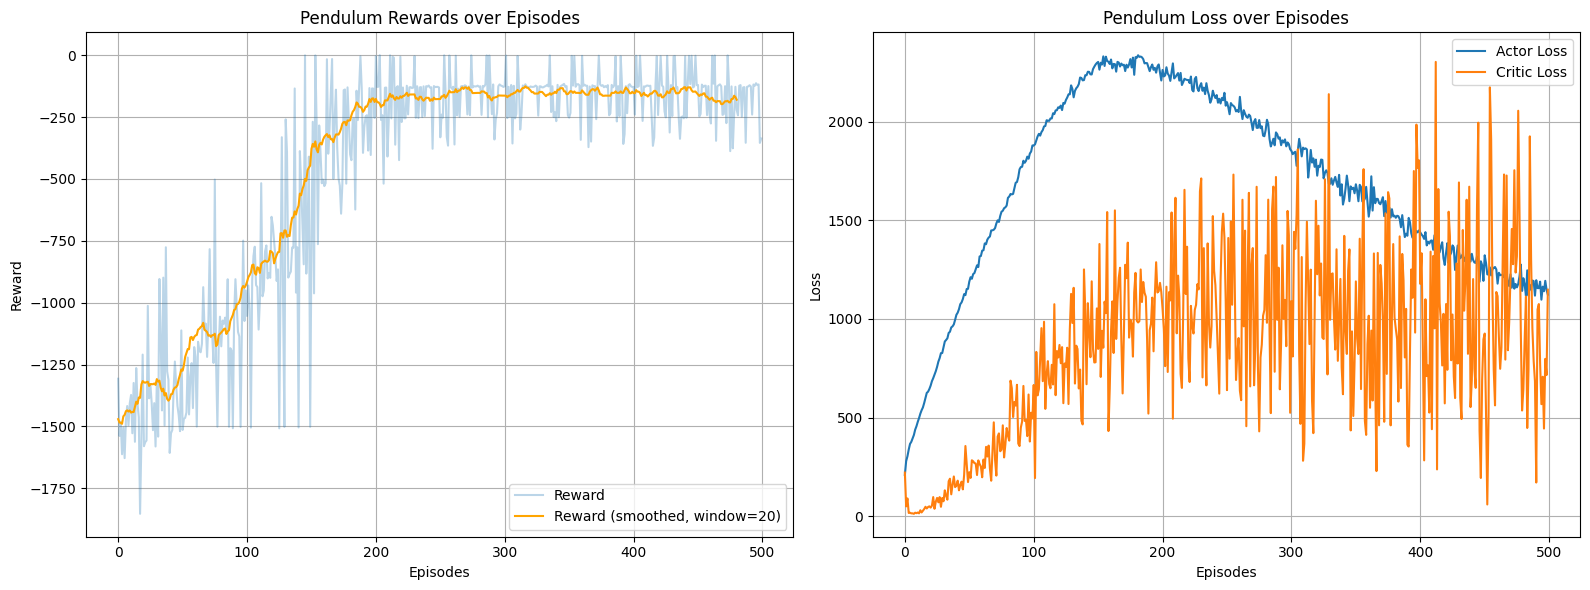

In [13]:
x_axis = np.arange(TRAININGS_EPISODES)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linker plot
# Rewards Plot (blau) zeigt die rewards der Episoden
axes[0].plot(x_axis, all_rewards, alpha=0.3, label='Reward')

# Smooth version (orange) zeigt den Mittelwert über jeweils ein Fenster von 20 Episoden
window_size = 20
smoothed_rewards = np.convolve(all_rewards, np.ones(window_size)/window_size, mode='valid')

axes[0].plot(x_axis[:len(smoothed_rewards)], smoothed_rewards, label=f'Reward (smoothed, window={window_size})', color='orange')
axes[0].set_xlabel('Episodes')
axes[0].set_ylabel('Reward')
axes[0].set_title('Pendulum Rewards over Episodes')
axes[0].grid(True)
axes[0].legend()

# Loss Plot (rechts) für Actor/Critic loss
axes[1].plot(x_axis, all_actor_losses, label='Actor Loss')
axes[1].plot(x_axis, all_critic_losses, label='Critic Loss')
axes[1].set_xlabel('Episodes')
axes[1].set_ylabel('Loss')
axes[1].set_title('Pendulum Loss over Episodes')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


Lasst uns mal schauen, wie gut unser Agent jetzt spielt. Dazu lassen wir ihn 10 Episoden spielen und schauen uns die Belohnungen an.

In [9]:
dqn_agent.set_mode(is_training=False)  # Wir setzen den Agenten in den Evaluierungsmodus

TEST_EPISODES = 10  # Anzahl der Testepisoden

# Wir tracken die Belohnungen
all_rewards = []

env = gymnasium.make('Pendulum-v1', render_mode="human")
for i in range(TEST_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
    done = False
    total_reward = 0
    loss = 0

    while not done:
        env.render()

        # jetzt fragen wir den KI-Agenten nach einer Aktion (ohne Exploration noise)
        action = dqn_agent.act(state)

        # Führe die Aktion aus
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Speichere die gesamte Belohnung.
        total_reward += reward

        # Konvertiere Zahlen/Vektoren in torch.Tensors
        action = torch.tensor(action, device = DEVICE, dtype = torch.float32)
        reward = torch.tensor(reward, device = DEVICE, dtype = torch.float32)
        done = torch.tensor(terminated or truncated, device = DEVICE, dtype = torch.int)
        next_state = torch.tensor(next_state, device = DEVICE, dtype = torch.float32)

        # Aktualisiere State
        state = next_state
    all_rewards.append(total_reward)
    print(f"Test Episode {i+1}/{TEST_EPISODES} | Reward: {total_reward}")

print(f"Mean Reward: {np.mean(all_rewards)}")

env.close()

Test Episode 1/10 | Reward: -119.12311229739778
Test Episode 2/10 | Reward: -515.4971145627642


KeyboardInterrupt: 

#### Das wars! Du hast deine erste RL-KI gebaut! Super!!! 🚀🚀🚀

<div style="display: flex; justify-content: center;">
<img src="https://c.tenor.com/Slufj9jTjn0AAAAC/tenor.gif">
</div>

## Optional 💭
Wenn du möchtest, kannst du entweder versuchen
1. Das Netzwerk zu verbessern, indem du
    1) die Hyperparameter anpasst oder
    2) die Architektur änderst
2. Eine andere Umgebung ausprobieren, z.B. [Car Racing](https://gymnasium.farama.org/environments/classic_control/cartpole/)
   <div style="display: flex; justify-content: center;">
    <img src="https://gymnasium.farama.org/_images/car_racing.gif">
    </div>

## Empfehlungen 💡💡💡
1. **Wenn du wissen willst, wie neuronale Netzwerke funktionieren**, empfehle ich dir, dir das [Micrograd Video von Andrej Karpathy](https://youtu.be/VMj-3S1tku0?si=T0Lu9Yy4aFFeraIZ) anzuschauen. Um neuronale Netze zu verstehen, braucht man etwas Mathe, aber das schafft man gut.

<div style="display: flex; justify-content: center;">
<iframe width="560" height="315" src="https://www.youtube.com/embed/VMj-3S1tku0?si=D7_ygttDShhJ2Zrc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>

2. Willst du dir einen RL-Agenten anschauen, welcher **Spiele lernen kann zu spielen besser als jeder Mensch**? Dann schau dir unser [Laserhockey Github-Repository](https://github.com/danielflat/Laser-Hockey) an.

<div style="display: flex; justify-content: center;">
    <img src="https://raw.githubusercontent.com/danielflat/Laser-Hockey/dev-flat/assets/hockey_gameplay_example.gif">
</div>